In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    accuracy_score, classification_report, confusion_matrix,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Check for mRMR
try:
    from mrmr import mrmr_classif
    HAS_MRMR = True
except ImportError:
    HAS_MRMR = False
    print("Warning: mrmr-selection not installed. Will skip mRMR step.")

# Check for UMAP
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed. UMAP plots will be skipped.")

# Check for GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f">>> Running on: {DEVICE}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check for CuPy (GPU mRMR)
try:
    import cupy as cp
    HAS_CUPY = True
    print(">>> CuPy detected. GPU mRMR enabled.")
except ImportError:
    HAS_CUPY = False
    print(">>> CuPy NOT detected. GPU mRMR disabled.")


>>> Running on: cuda
>>> CuPy detected. GPU mRMR enabled.


In [2]:
# --- BEST HYPERPARAMETERS (From Optuna) ---
BEST_PARAMS = {
    'latent_dim': 32, 
    'hidden_dim': 128, 
    'fusion_hidden_dim': 48, 
    'dropout_encoder': 0.3, 
    'dropout_rate': 0.4, 
    'lr_fine': 0.000865, 
    'weight_decay': 0.000435, 
    'noise_level': 0.14, 
    'focal_gamma': 3.5, 
    'alpha_scale': 1.5
}

In [3]:
# {'latent_dim': 32, 'hidden_dim': 128, 'dropout_encoder': 0.23269860856000385, 'dropout_rate': 0.41453024325279964, 'lr_fine': 0.00086337557519539, 'weight_decay': 0.0004341069258651662, 'noise_level': 0.0668153186186441, 'focal_gamma': 1.7401231935140207, 'alpha_scale': 1.5494811111935625}

In [4]:
class PerOmicCMAE(nn.Module):
    """Encoder for Supervised Learning"""
    def __init__(self, input_dim, latent_dim=64, hidden_dim=256, dropout_encoder=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim), 
            nn.GELU(),
            nn.Dropout(dropout_encoder),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, noise_level=0.0, noise_type='gaussian'):
        # Noise Injection during training
        if self.training and noise_level > 0:
            if noise_type == 'gaussian':
                noise = torch.randn_like(x) * noise_level
                x_corrupted = x + noise
            elif noise_type == 'uniform':
                noise = (torch.rand_like(x) - 0.5) * 2 * noise_level
                x_corrupted = x + noise
            elif noise_type == 'dropout':
                mask = torch.bernoulli(torch.ones_like(x) * (1 - noise_level))
                x_corrupted = x * mask
            else:
                x_corrupted = x
        else:
            x_corrupted = x

        z = self.encoder(x_corrupted)
        return z


class GatedAttentionFusion(nn.Module):
    """Gated Attention Fusion"""
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        self.gate_rna = nn.Linear(latent_dim, 1)
        self.gate_meth = nn.Linear(latent_dim, 1)
        self.gate_clin = nn.Linear(latent_dim, 1) 
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        self.drop_rate = dropout_rate

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        if apply_dropout and self.training:
            if torch.rand(1).item() < self.drop_rate: z_rna = torch.zeros_like(z_rna)
            if torch.rand(1).item() < self.drop_rate: z_meth = torch.zeros_like(z_meth)
            if torch.rand(1).item() < self.drop_rate: z_clin = torch.zeros_like(z_clin)

        w_rna = torch.sigmoid(self.gate_rna(z_rna))
        w_meth = torch.sigmoid(self.gate_meth(z_meth))
        w_clin = torch.sigmoid(self.gate_clin(z_clin))

        z_fused = torch.cat([w_rna * z_rna, w_meth * z_meth, w_clin * z_clin], dim=1)
        
        return self.classifier(z_fused), z_fused


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                if self.alpha.device != inputs.device:
                    self.alpha = self.alpha.to(inputs.device)
                alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [5]:
def load_raw_aligned_data():
    print(f"\n>>> LOADING RAW ALIGNED DATA")
    pheno_path = "Data/phenotype_clean.csv"
    if not os.path.exists(pheno_path):
        raise FileNotFoundError(f"{pheno_path} not found.")

    pheno = pd.read_csv(pheno_path, index_col=0)
    SUBTYPES_OF_INTEREST = [
        'Leiomyosarcoma, NOS', 'Dedifferentiated liposarcoma',
        'Undifferentiated sarcoma', 'Fibromyxosarcoma'
    ]
    col_name = 'primary_diagnosis.diagnoses'
    mask = pheno[col_name].isin(SUBTYPES_OF_INTEREST)
    pheno = pheno[mask]

    def load_omic(path, name):
        if not os.path.exists(path): return None
        df = pd.read_csv(path, index_col=0)
        df = df.T  # samples x features
        return df

    rna = load_omic("Data/expression_log.csv", "RNA")
    meth = load_omic("Data/methylation_mvalues.csv", "Methylation")
    cnv = load_omic("Data/cnv_log.csv", "CNV")

    common_samples = pheno.index.intersection(rna.index).intersection(meth.index).intersection(cnv.index)
    print(f"  Common Samples: {len(common_samples)}")

    pheno = pheno.loc[common_samples]
    rna = rna.loc[common_samples]
    meth = meth.loc[common_samples]
    cnv = cnv.loc[common_samples]

    le = LabelEncoder()
    Y = le.fit_transform(pheno[col_name])
    
    class_counts = np.bincount(Y)
    class_weights = len(Y) / (len(class_counts) * class_counts)
    class_weights = class_weights / class_weights.sum()
    
    return rna, meth, cnv, Y, le.classes_, class_weights

In [6]:
# --- Advanced Feature Preparation Helpers ---
import time

def f_classif_gpu(X, y):
    """Compute ANOVA F-value on GPU."""
    n_samples, n_features = X.shape
    classes = cp.unique(y)
    n_classes = len(classes)
    
    mean_total = cp.mean(X, axis=0)
    var_total = cp.var(X, axis=0)
    ss_total = var_total * n_samples
    
    ss_between = cp.zeros(n_features, dtype=cp.float32)
    
    for c in classes:
        mask = (y == c)
        n_c = cp.sum(mask)
        mean_c = cp.mean(X[mask], axis=0)
        ss_between += n_c * (mean_c - mean_total)**2
        
    ss_within = ss_total - ss_between
    
    df_between = n_classes - 1
    df_within = n_samples - n_classes
    
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    
    f_stat = cp.divide(ms_between, ms_within)
    f_stat = cp.nan_to_num(f_stat, nan=0.0)
    return f_stat

def correlation_gpu(X, y):
    """Compute Pearson correlation on GPU."""
    X_centered = X - X.mean(axis=0)
    y_centered = y - y.mean()
    
    numerator = cp.dot(y_centered, X_centered)
    X_ss = cp.sum(X_centered**2, axis=0)
    y_ss = cp.sum(y_centered**2)
    
    denominator = cp.sqrt(X_ss * y_ss)
    corr = numerator / denominator
    return cp.abs(corr)

def mrmr_gpu_impl(X, y, K):
    """GPU accelerated mRMR."""
    # Move to GPU if not already
    X_gpu = cp.asarray(X, dtype=cp.float32)
    y_gpu = cp.asarray(y, dtype=cp.int32)
    
    n_samples, n_features = X_gpu.shape
    
    # 1. Relevance
    relevance = f_classif_gpu(X_gpu, y_gpu)
    
    selected_indices = []
    candidate_mask = cp.ones(n_features, dtype=bool)
    redundancy = cp.zeros(n_features, dtype=cp.float32)
    
    for k in range(K):
        if k == 0:
            scores = relevance
        else:
            scores = relevance - (redundancy / k)
            
        current_scores = scores.copy()
        current_scores[~candidate_mask] = -np.inf 
        
        best_idx = int(cp.argmax(current_scores))
        selected_indices.append(best_idx)
        candidate_mask[best_idx] = False
        
        if k < K - 1:
            last_selected_feature = X_gpu[:, best_idx]
            new_corrs = correlation_gpu(X_gpu, last_selected_feature)
            redundancy += new_corrs
            
    return selected_indices

def variance_filter(train_vals, val_vals, top_k):
    """Filter features by variance, calculated on train data only."""
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])
    
    # Use nanvar to be safe against NaNs
    vars = np.nanvar(train_vals, axis=0)
    # Indices of top_k variance
    top_idx = np.argpartition(vars, -top_k)[-top_k:]
    # Sort indices to keep order (optional but nice)
    top_idx = np.sort(top_idx)
    
    return train_vals[:, top_idx], val_vals[:, top_idx], top_idx

def mrmr_filter(train_vals, val_vals, train_y, top_k, feat_names):
    """Apply mRMR feature selection on Training data, apply to Validation."""
    if train_vals.shape[1] <= top_k:
        return train_vals, val_vals, np.arange(train_vals.shape[1])
        
    # GPU ACCELERATION
    if HAS_CUPY:
        try:
            # print(f"   [GPU] Running mRMR on {train_vals.shape}...")
            selected_indices = mrmr_gpu_impl(train_vals, train_y, top_k)
            # Ensure indices are python list of ints
            if hasattr(selected_indices, 'get'): selected_indices = selected_indices.get()
            selected_indices = list(selected_indices)
            
            return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices
        except Exception as e:
            print(f"   [GPU] mRMR Failed: {e}. Falling back to CPU.")
            # Fallthrough to CPU
            
    if not HAS_MRMR: 
        return variance_filter(train_vals, val_vals, top_k) # Fallback
    
    # mRMR requires DataFrame with columns
    df_train = pd.DataFrame(train_vals, columns=[f"f_{i}" for i in range(train_vals.shape[1])])
    y_series = pd.Series(train_y)
    
    # Select features
    selected_feats = mrmr_classif(X=df_train, y=y_series, K=top_k, show_progress=False)
    
    # Map back to indices
    selected_indices = [int(f.split('_')[1]) for f in selected_feats]
    
    return train_vals[:, selected_indices], val_vals[:, selected_indices], selected_indices

def prepare_fold_data_advanced(t_idx, v_idx, df_rna, df_meth, df_cnv, Y):
    """Pipeline: Variance (Top 5k) -> KNN Impute -> mRMR (Top 600) -> Scale"""
    
    # 1. Split
    tr_r, val_r = df_rna.iloc[t_idx].values, df_rna.iloc[v_idx].values
    tr_m, val_m = df_meth.iloc[t_idx].values, df_meth.iloc[v_idx].values
    tr_c, val_c = df_cnv.iloc[t_idx].values, df_cnv.iloc[v_idx].values
    y_tr = Y[t_idx]
    
    # 2. Variance Filter (Speed up KNN)
    # Methylation is huge, filter heavily first. Others less so.
    tr_r, val_r, _ = variance_filter(tr_r, val_r, top_k=5000)
    tr_m, val_m, _ = variance_filter(tr_m, val_m, top_k=10000)
    tr_c, val_c, _ = variance_filter(tr_c, val_c, top_k=7000)
    
    # 3. KNN Imputation
    imp = KNNImputer(n_neighbors=12)
    tr_r = imp.fit_transform(tr_r); val_r = imp.transform(val_r)
    tr_m = imp.fit_transform(tr_m); val_m = imp.transform(val_m)
    tr_c = imp.fit_transform(tr_c); val_c = imp.transform(val_c)
    
    # 4. mRMR Feature Selection (Refine for Relevance)
    # Target dimensions similar to source paper or reasonable dense input
    tr_r, val_r, _ = mrmr_filter(tr_r, val_r, y_tr, top_k=600, feat_names=None)
    tr_m, val_m, _ = mrmr_filter(tr_m, val_m, y_tr, top_k=500, feat_names=None)
    tr_c, val_c, _ = mrmr_filter(tr_c, val_c, y_tr, top_k=400, feat_names=None)
    
    # 5. Standard Scaling
    sc = StandardScaler()
    tr_r = sc.fit_transform(tr_r); val_r = sc.transform(val_r)
    tr_m = sc.fit_transform(tr_m); val_m = sc.transform(val_m)
    tr_c = sc.fit_transform(tr_c); val_c = sc.transform(val_c)
    
    return (
        torch.FloatTensor(tr_r).to(DEVICE), torch.FloatTensor(val_r).to(DEVICE), tr_r.shape[1],
        torch.FloatTensor(tr_m).to(DEVICE), torch.FloatTensor(val_m).to(DEVICE), tr_m.shape[1],
        torch.FloatTensor(tr_c).to(DEVICE), torch.FloatTensor(val_c).to(DEVICE), tr_c.shape[1],
        torch.LongTensor(y_tr).to(DEVICE), torch.LongTensor(Y[v_idx]).to(DEVICE)
    )


In [7]:
def run_final_evaluation(rna_df, meth_df, cnv_df, Y, class_names, class_weights, params):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # Storage for analysis
    all_preds = np.zeros(len(Y))
    all_targets = np.zeros(len(Y))
    all_latent = np.zeros((len(Y), params['latent_dim']*3)) # Concatenated latent space for visualization
    
    metrics = {
        'f1_macro': [], 'f1_micro': [], 'precision': [], 'recall': [], 'accuracy': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
        print(f"\n{'='*20} Fold {fold+1} / 5 {'='*20}")
        
        # Data Prep
        (tr_r, val_r, dim_r, 
         tr_m, val_m, dim_m, 
         tr_c, val_c, dim_c, 
         y_tr, y_val) = prepare_fold_data_advanced(train_idx, val_idx, rna_df, meth_df, cnv_df, Y)
        
        print(f"   Input Dims: RNA={dim_r}, Meth={dim_m}, CNV={dim_c}")
        
        # Model Init
        enc_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        fusion = GatedAttentionFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
        
        optimizer = optim.AdamW(
            list(enc_r.parameters()) + list(enc_m.parameters()) + 
            list(enc_c.parameters()) + list(fusion.parameters()),
            lr=params['lr_fine'], weight_decay=params['weight_decay']
        )
        
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        alpha = torch.FloatTensor(class_weights * params['alpha_scale']).to(DEVICE)
        criterion = FocalLoss(gamma=params['focal_gamma'], alpha=alpha)
        
        # Training
        best_loss = float('inf')
        patience = 20
        cur_pat = 0
        best_state = None
        
        for epoch in range(300):
            enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
            
            z_r = enc_r(tr_r, noise_level=params['noise_level'])
            z_m = enc_m(tr_m, noise_level=params['noise_level'])
            z_c = enc_c(tr_c, noise_level=params['noise_level'])
            
            logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
            loss = criterion(logits, y_tr)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Validation
            enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
            with torch.no_grad():
                v_z_r = enc_r(val_r)
                v_z_m = enc_m(val_m)
                v_z_c = enc_c(val_c)
                v_logits, v_latent = fusion(v_z_r, v_z_m, v_z_c)
                val_loss = criterion(v_logits, y_val).item()
                
            scheduler.step(val_loss)
            
            if val_loss < best_loss:
                best_loss = val_loss
                cur_pat = 0
                # Save Predictions for Best Epoch
                v_preds = v_logits.argmax(dim=1).cpu().numpy()
                v_targets = y_val.cpu().numpy()
                v_embeddings = v_latent.cpu().numpy()
            else:
                cur_pat += 1
            
            if cur_pat >= patience:
                break
        
        # Record Fold Results
        all_preds[val_idx] = v_preds
        all_targets[val_idx] = v_targets
        all_latent[val_idx] = v_embeddings
        
        f1_mac = f1_score(v_targets, v_preds, average='macro')
        acc = accuracy_score(v_targets, v_preds)
        
        metrics['f1_macro'].append(f1_mac)
        metrics['f1_micro'].append(f1_score(v_targets, v_preds, average='micro'))
        metrics['precision'].append(precision_score(v_targets, v_preds, average='macro'))
        metrics['recall'].append(recall_score(v_targets, v_preds, average='macro'))
        metrics['accuracy'].append(acc)
        
        print(f"   Fold Result: F1-Macro={f1_mac:.4f}, Accuracy={acc:.4f}, Precision={precision_score(v_targets, v_preds, average='macro'):.4f}, Recall={recall_score(v_targets, v_preds, average='macro'):.4f}")

    return metrics, all_preds, all_targets, all_latent

In [8]:
# Load Data
try:
    rna_df, meth_df, cnv_df, Y, class_names, class_weights = load_raw_aligned_data()
    
    # Run Eval
    metrics, all_preds, all_targets, all_latent = run_final_evaluation(
        rna_df, meth_df, cnv_df, Y, class_names, class_weights, BEST_PARAMS
    )
    
    # --- Reporting ---
    print(f"\n{'='*30}")
    print("FINAL CLASSIFICATION METRICS")
    print(f"{'='*30}")
    print(f"F1 Macro:  {np.mean(metrics['f1_macro']):.4f} (+/- {np.std(metrics['f1_macro']):.4f})")
    print(f"F1 Micro:  {np.mean(metrics['f1_micro']):.4f} (+/- {np.std(metrics['f1_micro']):.4f})")
    print(f"Precision: {np.mean(metrics['precision']):.4f} (+/- {np.std(metrics['precision']):.4f})")
    print(f"Recall:    {np.mean(metrics['recall']):.4f} (+/- {np.std(metrics['recall']):.4f})")
    print(f"Accuracy:  {np.mean(metrics['accuracy']):.4f}")
    
    # --- Clustering Metrics ---
    print(f"\n{'='*30}")
    print("CLUSTERING METRICS (Latent Space)")
    print(f"{'='*30}")
    
    # 1. True Labels Silhouette
    sil_true = silhouette_score(all_latent, all_targets)
    print(f"Silhouette Score (True Labels): {sil_true:.4f}")
    
    # 2. K-Means Clustering
    kmeans = KMeans(n_clusters=len(class_names), random_state=SEED)
    kmeans_preds = kmeans.fit_predict(all_latent)
    
    sil_km = silhouette_score(all_latent, kmeans_preds)
    ari = adjusted_rand_score(all_targets, kmeans_preds)
    nmi = normalized_mutual_info_score(all_targets, kmeans_preds)
    
    print(f"Silhouette Score (K-Means):   {sil_km:.4f}")
    print(f"Adjusted Rand Index (ARI):    {ari:.4f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()


>>> LOADING RAW ALIGNED DATA
  Common Samples: 205

==================== Fold 1 / 5 ====================
   Input Dims: RNA=600, Meth=500, CNV=400
   Fold Result: F1-Macro=0.8160, Accuracy=0.9024, Precision=0.8194, Recall=0.8250

==================== Fold 2 / 5 ====================
   Input Dims: RNA=600, Meth=500, CNV=400
   Fold Result: F1-Macro=0.7549, Accuracy=0.8537, Precision=0.7714, Recall=0.7547

==================== Fold 3 / 5 ====================
   Input Dims: RNA=600, Meth=500, CNV=400
   Fold Result: F1-Macro=0.6764, Accuracy=0.7317, Precision=0.6821, Recall=0.7459

==================== Fold 4 / 5 ====================
   Input Dims: RNA=600, Meth=500, CNV=400
   Fold Result: F1-Macro=0.6380, Accuracy=0.7317, Precision=0.6338, Recall=0.6496

==================== Fold 5 / 5 ====================
   Input Dims: RNA=600, Meth=500, CNV=400
   Fold Result: F1-Macro=0.6754, Accuracy=0.7317, Precision=0.6778, Recall=0.6784

FINAL CLASSIFICATION METRICS
F1 Macro:  0.7121 (+/- 0.064

Running t-SNE...
Running UMAP...


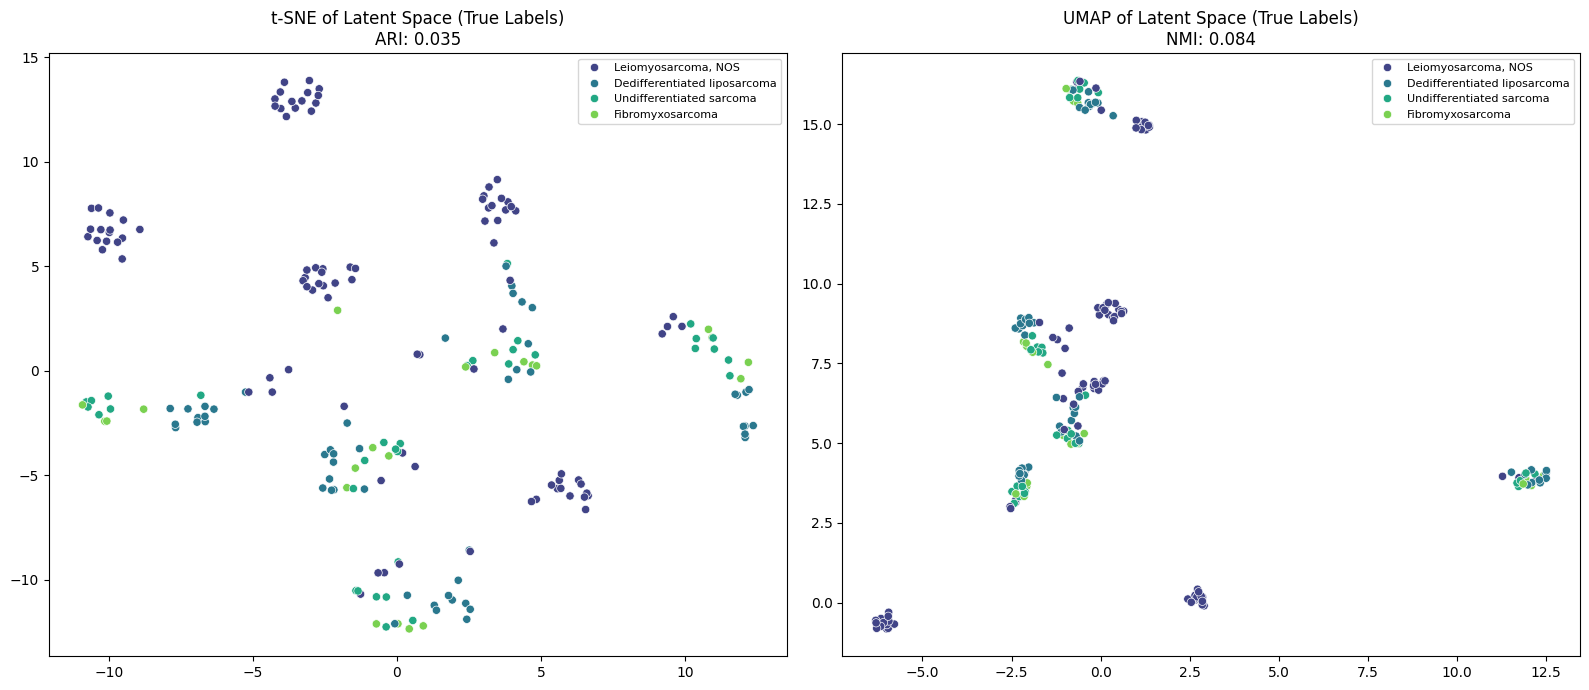

In [9]:
# --- Visualizations ---
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# TSNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
z_tsne = tsne.fit_transform(all_latent)

sns.scatterplot(
    x=z_tsne[:,0], y=z_tsne[:,1], 
    hue=[class_names[int(i)] for i in all_targets], 
    palette='viridis', ax=axes[0]
)
axes[0].set_title(f't-SNE of Latent Space (True Labels)\nARI: {ari:.3f}')
axes[0].legend(prop={'size': 8})

# UMAP (if available)
if HAS_UMAP:
    print("Running UMAP...")
    reducer = umap.UMAP(random_state=SEED)
    z_umap = reducer.fit_transform(all_latent)
    
    sns.scatterplot(
        x=z_umap[:,0], y=z_umap[:,1], 
        hue=[class_names[int(i)] for i in all_targets], 
        palette='viridis', ax=axes[1]
    )
    axes[1].set_title(f'UMAP of Latent Space (True Labels)\nNMI: {nmi:.3f}')
    axes[1].legend(prop={'size': 8})
else:
    axes[1].text(0.5, 0.5, 'UMAP Not Installed', ha='center')

plt.tight_layout()
plt.savefig('cluster_analysis.png', dpi=300)
plt.show()

>>> Running Independent K-Means Clustering...
    Number of Clusters (k): 4
    Silhouette Score: 0.1636
    Adjusted Rand Index (ARI):    0.0350
    Normalized Mutual Info (NMI): 0.0837


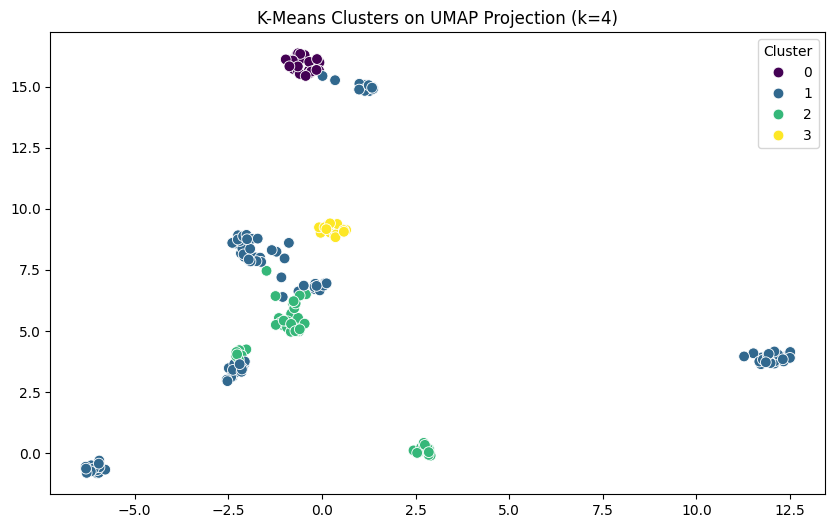

In [10]:
# --- K-Means Clustering Analysis ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Ensure latent data is available
if 'all_latent' in locals():
    print(f">>> Running Independent K-Means Clustering...")

    # Determine K (number of clusters)
    # Uses len(class_names) if available, otherwise defaults to 4
    n_clusters = len(class_names) if 'class_names' in locals() else 4
    rand_seed = SEED if 'SEED' in locals() else 42
    
    print(f"    Number of Clusters (k): {n_clusters}")

    # 1. Fit K-Means
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=rand_seed)
    cluster_labels = kmeans_model.fit_predict(all_latent)

    # 2. Metrics
    sil_score = silhouette_score(all_latent, cluster_labels)
    print(f"    Silhouette Score: {sil_score:.4f}")

    if 'all_targets' in locals():
        ari_score = adjusted_rand_score(all_targets, cluster_labels)
        nmi_score = normalized_mutual_info_score(all_targets, cluster_labels)
        print(f"    Adjusted Rand Index (ARI):    {ari_score:.4f}")
        print(f"    Normalized Mutual Info (NMI): {nmi_score:.4f}")

    # 3. Visualization
    # Plots the K-Means clusters on top of existing UMAP or t-SNE results
    if 'z_umap' in locals():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=z_umap[:, 0], y=z_umap[:, 1], hue=cluster_labels, palette='viridis', s=60, legend='full')
        plt.title(f'K-Means Clusters on UMAP Projection (k={n_clusters})')
        plt.legend(title='Cluster')
        plt.show()
    elif 'z_tsne' in locals():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=cluster_labels, palette='viridis', s=60, legend='full')
        plt.title(f'K-Means Clusters on t-SNE Projection (k={n_clusters})')
        plt.legend(title='Cluster')
        plt.show()
    else:
        print("    Note: 'z_umap' or 'z_tsne' not found. Skipping visualization.")

else:
    print("Error: 'all_latent' variable not found. Please run the evaluation cells above first.")

In [11]:
# ==========================================
#      DEDICATED ABLATION STUDY CELL
# ==========================================

import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

# 1. Define Ablation Components
# ------------------------------------------
class SimpleConcatFusion(nn.Module):
    """
    Ablation Variant: Removes the Gated Attention mechanism.
    Just concatenates the modalities directly.
    """
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        # Direct classifier after concatenation (input dim = latent * 3)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        # Simply concatenate without weighting
        z_fused = torch.cat([z_rna, z_meth, z_clin], dim=1) 
        return self.classifier(z_fused), z_fused

# 2. Pre-Compute Data Folds (Optimization)
# ------------------------------------------
# This prevents re-running expensive mRMR feature selection for every ablation experiment.
print("\n>>> Pre-computing 5-Fold Data Splits (to save time)...")
processed_folds = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
    print(f"   Processing Data for Fold {fold_idx+1}...")
    fold_data = prepare_fold_data_advanced(train_idx, val_idx, rna_df, meth_df, cnv_df, Y)
    processed_folds.append(fold_data)

print(">>> Data Pre-computation Complete.\n")

# 3. Ablation Runner Function
# ------------------------------------------
def run_single_ablation(ablation_name, params):
    print(f"--- Running Ablation: {ablation_name} ---")
    f1_scores = []
    
    for fold, data in enumerate(processed_folds):
        # Unpack pre-computed data
        (tr_r, val_r, dim_r, tr_m, val_m, dim_m, tr_c, val_c, dim_c, y_tr, y_val) = data
            
        # Initialize Standard Encoders
        enc_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        
        # --- ABLATION LOGIC: FUSION ---
        if 'No Gating' in ablation_name:
            fusion = SimpleConcatFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
        else:
            fusion = GatedAttentionFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
            
        optimizer = optim.AdamW(
            list(enc_r.parameters()) + list(enc_m.parameters()) + 
            list(enc_c.parameters()) + list(fusion.parameters()),
            lr=params['lr_fine'], weight_decay=params['weight_decay']
        )
        
        # --- ABLATION LOGIC: LOSS ---
        if 'No Focal' in ablation_name:
            # Use Standard CrossEntropy
            weights_t = torch.FloatTensor(class_weights).to(DEVICE)
            criterion = nn.CrossEntropyLoss(weight=weights_t)
        else:
            # Use Focal Loss (Default)
            alpha = torch.FloatTensor(class_weights * params['alpha_scale']).to(DEVICE)
            criterion = FocalLoss(gamma=params['focal_gamma'], alpha=alpha)
            
        # Training Loop
        best_f1 = 0.0
        patience = 15 # Slightly lower patience for ablation speed
        cur_pat = 0
        
        for epoch in range(150): # Cap epochs for speed
            enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
            
            z_r = enc_r(tr_r, noise_level=params['noise_level'])
            z_m = enc_m(tr_m, noise_level=params['noise_level'])
            z_c = enc_c(tr_c, noise_level=params['noise_level'])
            
            logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
            loss = criterion(logits, y_tr)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Eval
            enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
            with torch.no_grad():
                v_z_r = enc_r(val_r)
                v_z_m = enc_m(val_m)
                v_z_c = enc_c(val_c)
                v_logits, _ = fusion(v_z_r, v_z_m, v_z_c)
                v_preds = v_logits.argmax(dim=1).cpu().numpy()
                v_targets = y_val.cpu().numpy()
                val_f1 = f1_score(v_targets, v_preds, average='macro')
            
            if val_f1 > best_f1:
                best_f1 = val_f1
                cur_pat = 0
            else:
                cur_pat += 1
                if cur_pat >= patience: break
        
        f1_scores.append(best_f1)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print(f"Result {ablation_name}: F1-Macro = {mean_f1:.4f}\n")
    return mean_f1, std_f1

# 4. Execute Study
# ------------------------------------------
experiments = [
    'Baseline (Gated+Focal+Noise)',
    'Ablation 1: No Gating (Simple Concat)',
    'Ablation 2: No Focal Loss (CrossEntropy)'
]

results = {}

for exp in experiments:
    mean, std = run_single_ablation(exp, BEST_PARAMS)
    results[exp] = f"{mean:.4f} \u00B1 {std:.4f}"

# 5. Display Results
# ------------------------------------------
print("\n" + "="*40)
print("     FINAL ABLATION STUDY RESULTS")
print("="*40)
ablation_df = pd.DataFrame.from_dict(results, orient='index', columns=['F1-Macro Score'])
try:
    display(ablation_df)
except NameError:
    print(ablation_df)


>>> Pre-computing 5-Fold Data Splits (to save time)...
   Processing Data for Fold 1...
   Processing Data for Fold 2...
   Processing Data for Fold 3...
   Processing Data for Fold 4...
   Processing Data for Fold 5...
>>> Data Pre-computation Complete.

--- Running Ablation: Baseline (Gated+Focal+Noise) ---
Result Baseline (Gated+Focal+Noise): F1-Macro = 0.6952

--- Running Ablation: Ablation 1: No Gating (Simple Concat) ---
Result Ablation 1: No Gating (Simple Concat): F1-Macro = 0.7773

--- Running Ablation: Ablation 2: No Focal Loss (CrossEntropy) ---
Result Ablation 2: No Focal Loss (CrossEntropy): F1-Macro = 0.7481


     FINAL ABLATION STUDY RESULTS


,F1-Macro Score
Baseline (Gated+Focal+Noise),0.6952 ± 0.1301
Ablation 1: No Gating (Simple Concat),0.7773 ± 0.0647
Ablation 2: No Focal Loss (CrossEntropy),0.7481 ± 0.1007


In [12]:
# ==========================================
#    ABLATION STUDY (Metric: ACCURACY)
# ==========================================

import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Reuse or Define Ablation Components
# ------------------------------------------
# Check if SimpleConcatFusion is already defined from previous cell
if 'SimpleConcatFusion' not in locals():
    class SimpleConcatFusion(nn.Module):
        """
        Ablation Variant: Removes the Gated Attention mechanism.
        Just concatenates the modalities directly.
        """
        def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
            super().__init__()
            self.classifier = nn.Sequential(
                nn.Linear(latent_dim * 3, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim, num_classes)
            )

        def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
            z_fused = torch.cat([z_rna, z_meth, z_clin], dim=1) 
            return self.classifier(z_fused), z_fused

# 2. Pre-Compute Data Folds (Reuse if available)
# ------------------------------------------
if 'processed_folds' not in locals():
    print("\n>>> Pre-computing 5-Fold Data Splits (to save time)...")
    processed_folds = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
        print(f"   Processing Data for Fold {fold_idx+1}...")
        fold_data = prepare_fold_data_advanced(train_idx, val_idx, rna_df, meth_df, cnv_df, Y)
        processed_folds.append(fold_data)
    print(">>> Data Pre-computation Complete.\n")
else:
    print(">>> Using pre-computed data folds from memory.")

# 3. Accuracy-Based Ablation Runner
# ------------------------------------------
def run_ablation_accuracy(ablation_name, params):
    print(f"--- Running Ablation (Accuracy): {ablation_name} ---")
    acc_scores = []
    
    for fold, data in enumerate(processed_folds):
        (tr_r, val_r, dim_r, tr_m, val_m, dim_m, tr_c, val_c, dim_c, y_tr, y_val) = data
            
        # Init Models
        enc_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        
        # Logic: Fusion
        if 'No Gating' in ablation_name:
            fusion = SimpleConcatFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
        else:
            fusion = GatedAttentionFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
            
        optimizer = optim.AdamW(
            list(enc_r.parameters()) + list(enc_m.parameters()) + 
            list(enc_c.parameters()) + list(fusion.parameters()),
            lr=params['lr_fine'], weight_decay=params['weight_decay']
        )
        
        # Logic: Loss
        if 'No Focal' in ablation_name:
            weights_t = torch.FloatTensor(class_weights).to(DEVICE)
            criterion = nn.CrossEntropyLoss(weight=weights_t)
        else:
            alpha = torch.FloatTensor(class_weights * params['alpha_scale']).to(DEVICE)
            criterion = FocalLoss(gamma=params['focal_gamma'], alpha=alpha)
            
        # Training
        best_acc = 0.0
        patience = 15
        cur_pat = 0
        
        for epoch in range(150):
            enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
            
            z_r = enc_r(tr_r, noise_level=params['noise_level'])
            z_m = enc_m(tr_m, noise_level=params['noise_level'])
            z_c = enc_c(tr_c, noise_level=params['noise_level'])
            
            logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
            loss = criterion(logits, y_tr)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Eval (Metric: ACCURACY)
            enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
            with torch.no_grad():
                v_z_r = enc_r(val_r)
                v_z_m = enc_m(val_m)
                v_z_c = enc_c(val_c)
                v_logits, _ = fusion(v_z_r, v_z_m, v_z_c)
                v_preds = v_logits.argmax(dim=1).cpu().numpy()
                v_targets = y_val.cpu().numpy()
                
                val_acc = accuracy_score(v_targets, v_preds)
            
            if val_acc > best_acc:
                best_acc = val_acc
                cur_pat = 0
            else:
                cur_pat += 1
                if cur_pat >= patience: break
        
        acc_scores.append(best_acc)

    mean_acc = np.mean(acc_scores)
    std_acc = np.std(acc_scores)
    print(f"Result {ablation_name}: Accuracy = {mean_acc:.4f}\n")
    return mean_acc, std_acc

# 4. Execute Study & Display
# ------------------------------------------
experiments = [
    'Baseline (Gated+Focal+Noise)',
    'Ablation 1: No Gating (Simple Concat)',
    'Ablation 2: No Focal Loss (CrossEntropy)',
    'Ablation 3: No Gating + No Focal (Simplest)'
]

results_acc = {}

for exp in experiments:
    mean, std = run_ablation_accuracy(exp, BEST_PARAMS)
    results_acc[exp] = f"{mean:.4f} \u00B1 {std:.4f}"

print("\n" + "="*40)
print("   ABLATION RESULTS (ACCURACY)")
print("="*40)
acc_df = pd.DataFrame.from_dict(results_acc, orient='index', columns=['Accuracy'])
try:
    display(acc_df)
except NameError:
    print(acc_df)

>>> Using pre-computed data folds from memory.
--- Running Ablation (Accuracy): Baseline (Gated+Focal+Noise) ---
Result Baseline (Gated+Focal+Noise): Accuracy = 0.7707

--- Running Ablation (Accuracy): Ablation 1: No Gating (Simple Concat) ---
Result Ablation 1: No Gating (Simple Concat): Accuracy = 0.8439

--- Running Ablation (Accuracy): Ablation 2: No Focal Loss (CrossEntropy) ---
Result Ablation 2: No Focal Loss (CrossEntropy): Accuracy = 0.7756

--- Running Ablation (Accuracy): Ablation 3: No Gating + No Focal (Simplest) ---
Result Ablation 3: No Gating + No Focal (Simplest): Accuracy = 0.8585


   ABLATION RESULTS (ACCURACY)


,Accuracy
Baseline (Gated+Focal+Noise),0.7707 ± 0.0425
Ablation 1: No Gating (Simple Concat),0.8439 ± 0.0502
Ablation 2: No Focal Loss (CrossEntropy),0.7756 ± 0.0679
Ablation 3: No Gating + No Focal (Simplest),0.8585 ± 0.0497


>>> Calculating Modality Importance (using Best Model: Simple Concat)...

   BIOLOGICAL MODALITY IMPACT (%)
RNA: 52.44% contribution
Methylation: 42.68% contribution
CNV: 4.88% contribution


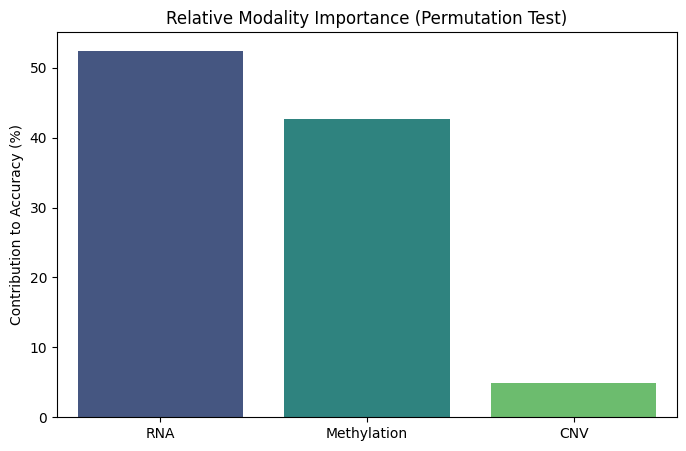

In [13]:
# ==========================================
#   MODALITY IMPORTANCE ANALYSIS (Permutation)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

def run_modality_importance(params):
    print(">>> Calculating Modality Importance (using Best Model: Simple Concat)...")
    
    # Store importance scores (drop in accuracy)
    importances = {'RNA': [], 'Methylation': [], 'CNV': []}
    
    for fold, data in enumerate(processed_folds):
        (tr_r, val_r, dim_r, tr_m, val_m, dim_m, tr_c, val_c, dim_c, y_tr, y_val) = data
        
        # 1. Train Best Model (Simple Concat)
        # ----------------------------------
        enc_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        enc_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
        fusion = SimpleConcatFusion(params['latent_dim'], len(class_names), params['dropout_rate'], params['fusion_hidden_dim']).to(DEVICE)
        
        optimizer = optim.AdamW(
            list(enc_r.parameters()) + list(enc_m.parameters()) + 
            list(enc_c.parameters()) + list(fusion.parameters()),
            lr=params['lr_fine'], weight_decay=params['weight_decay']
        )
        
        # Use Focal Loss (it worked best with Simple Concat)
        alpha = torch.FloatTensor(class_weights * params['alpha_scale']).to(DEVICE)
        criterion = FocalLoss(gamma=params['focal_gamma'], alpha=alpha)
        
        # Train Loop (Condensed)
        for epoch in range(100): # 100 epochs enough for importance check
            enc_r.train(); enc_m.train(); enc_c.train(); fusion.train()
            z_r = enc_r(tr_r); z_m = enc_m(tr_m); z_c = enc_c(tr_c)
            logits, _ = fusion(z_r, z_m, z_c, apply_dropout=True)
            loss = criterion(logits, y_tr)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
        # 2. Calculate Importance
        # ----------------------------------
        enc_r.eval(); enc_m.eval(); enc_c.eval(); fusion.eval()
        
        with torch.no_grad():
            # Get Baseline Accuracy
            z_r_base = enc_r(val_r)
            z_m_base = enc_m(val_m)
            z_c_base = enc_c(val_c)
            base_logits, _ = fusion(z_r_base, z_m_base, z_c_base)
            base_acc = accuracy_score(y_val.cpu(), base_logits.argmax(1).cpu())
            
            # A. Probe RNA
            # Shuffle RNA latent vectors to break their info
            z_r_shuff = z_r_base[torch.randperm(z_r_base.size(0))]
            logits_r, _ = fusion(z_r_shuff, z_m_base, z_c_base)
            acc_r = accuracy_score(y_val.cpu(), logits_r.argmax(1).cpu())
            importances['RNA'].append(base_acc - acc_r)
            
            # B. Probe Methylation
            z_m_shuff = z_m_base[torch.randperm(z_m_base.size(0))]
            logits_m, _ = fusion(z_r_base, z_m_shuff, z_c_base)
            acc_m = accuracy_score(y_val.cpu(), logits_m.argmax(1).cpu())
            importances['Methylation'].append(base_acc - acc_m)
            
            # C. Probe CNV
            z_c_shuff = z_c_base[torch.randperm(z_c_base.size(0))]
            logits_c, _ = fusion(z_r_base, z_m_base, z_c_shuff)
            acc_c = accuracy_score(y_val.cpu(), logits_c.argmax(1).cpu())
            importances['CNV'].append(base_acc - acc_c)

    return importances

# Run Metrics
imp_results = run_modality_importance(BEST_PARAMS)

# 3. Visualize & Report
# ----------------------------------
avg_imp = {k: np.mean(v) for k, v in imp_results.items()}
# Normalize to percentages
total = sum(avg_imp.values())
if total > 0:
    pct_imp = {k: (v / total) * 100 for k, v in avg_imp.items()}
else:
    pct_imp = avg_imp

print("\n" + "="*40)
print("   BIOLOGICAL MODALITY IMPACT (%)")
print("="*40)
for mod, val in pct_imp.items():
    print(f"{mod}: {val:.2f}% contribution")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(pct_imp.keys()), y=list(pct_imp.values()), palette='viridis')
plt.title('Relative Modality Importance (Permutation Test)')
plt.ylabel('Contribution to Accuracy (%)')
plt.show()


   SURVIVAL ANALYSIS
Matched 203 samples with survival data.


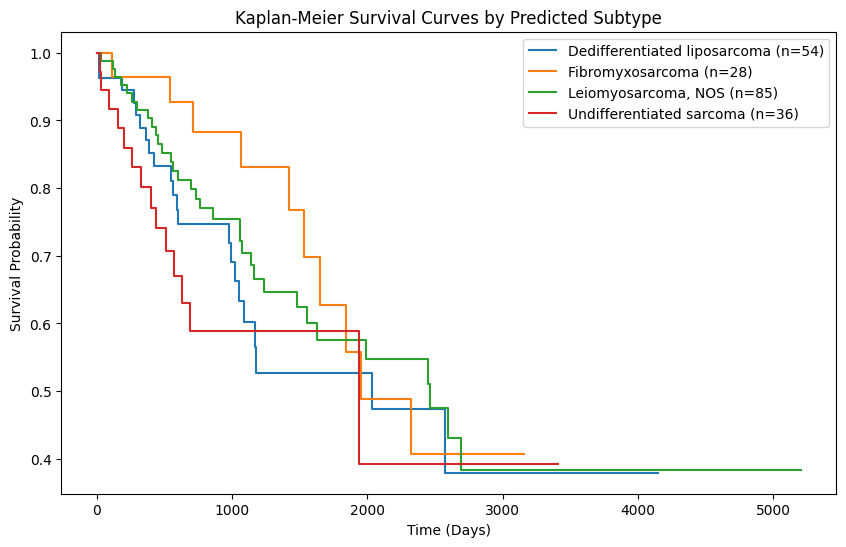

Log-Rank Test p-value: 4.3309e-01

>>> Cox Regression Results (Subtypes):


<lifelines.CoxPHFitter: fitted with 203 total observations, 124 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 203
number of events observed = 79
   partial log-likelihood = -366.87
         time fit was run = 2026-01-24 15:41:46 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
Subtype_Fibromyxosarcoma         -0.37      0.69      0.38           -1.12            0.38                0.33                1.46
Subtype_Leiomyosarcoma, NOS      -0.20      0.82      0.28           -0.74            0.34                0.48                1.41
Subtype_Undifferentiated sarcoma  0.22      1.25      0.34           -0.45            0.90                0.64                2.45

                                  cmp to     z    p  -log2(p)
covariate                                                    
Subtype_Fibromyxosarcoma            0.00 -0.97 0.33      1.59
Subtype_Leiomyosarcoma, NOS         0.00 -0.73 0.47      1.10
Subtype_Undifferentiated sarcoma    0.00  0.65 0.51      0.96
---
Concordance = 0.58
Partial AIC = 739.74
log-likelihood ratio test = 2.64 on 3 df
-log2(p) of ll-ratio test = 1.15


Concordance Index (C-index): 0.5818


In [14]:
# ==========================================
#   SURVIVAL ANALYSIS
# ==========================================
import os
import pandas as pd
import matplotlib.pyplot as plt
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import multivariate_logrank_test
    
    print("\n" + "="*40)
    print("   SURVIVAL ANALYSIS")
    print("="*40)
    
    # 1. Prepare Data
    # Match predictions to sample IDs from rna_df (which has the index)
    # Note: Ensure rna_df and all_preds are available from previous cells
    if 'rna_df' in locals() and 'all_preds' in locals():
        results_df = pd.DataFrame({
            'sample': rna_df.index,
            'subtype_pred': all_preds,
            'subtype_true': all_targets
        })
        
        surv_path = "RawData/TCGA-SARC.survival.tsv"
        if os.path.exists(surv_path):
            surv_df = pd.read_csv(surv_path, sep='\t')
            
            # Merge on sample ID
            merged_df = results_df.merge(surv_df, left_on='sample', right_on='sample', how='inner')
            print(f"Matched {len(merged_df)} samples with survival data.")
            
            if len(merged_df) > 0:
                # 2. Kaplan-Meier Analysis
                kmf = KaplanMeierFitter()
                plt.figure(figsize=(10, 6))
                
                # Plot for each predicted subtype
                for i, subtype in enumerate(class_names):
                    mask = (merged_df['subtype_pred'] == i)
                    if mask.sum() > 0:
                        kmf.fit(
                            durations=merged_df.loc[mask, 'OS.time'], 
                            event_observed=merged_df.loc[mask, 'OS'], 
                            label=f"{subtype} (n={mask.sum()})"
                        )
                        kmf.plot(ci_show=False)
                
                plt.title("Kaplan-Meier Survival Curves by Predicted Subtype")
                plt.xlabel("Time (Days)")
                plt.ylabel("Survival Probability")
                plt.show()
                
                # Log-Rank Test
                result_lr = multivariate_logrank_test(
                    merged_df['OS.time'], 
                    merged_df['subtype_pred'], 
                    merged_df['OS']
                )
                print(f"Log-Rank Test p-value: {result_lr.p_value:.4e}")
                
                # 3. Cox Regression Analysis
                cox_df = merged_df[['OS.time', 'OS', 'subtype_pred']].copy()
                # Map integer subtype to names for dummy encoding
                cox_df['Subtype'] = cox_df['subtype_pred'].apply(lambda x: class_names[int(x)])
                cox_df.dropna(inplace=True)
                
                # One-hot encode
                cox_df_encoded = pd.get_dummies(cox_df, columns=['Subtype'], drop_first=True)
                # Drop numeric subtype_pred
                if 'subtype_pred' in cox_df_encoded.columns:
                    cox_df_encoded = cox_df_encoded.drop(columns=['subtype_pred'])
                
                cph = CoxPHFitter()
                print("\n>>> Cox Regression Results (Subtypes):")
                try:
                    cph.fit(cox_df_encoded, duration_col='OS.time', event_col='OS')
                    cph.print_summary()
                    
                    # 4. C-Index
                    c_index = cph.concordance_index_
                    print(f"\nConcordance Index (C-index): {c_index:.4f}")
                except Exception as e_cox:
                     print(f"Cox fitting failed: {e_cox}")

            else:
                print("No overlapping samples found.")
        else:
            print(f"Survival file not found at {surv_path}")
    else:
        print("Required variables (rna_df, all_preds) not found. Run evaluation first.")

except ImportError:
    print("lifelines library not installed. Skipping Survival Analysis.")
except Exception as e:
    print(f"An error occurred: {e}")
